# Recomendaciones proyecto


1. **Rendimiento esperado:**  
   - No es necesario alcanzar un rendimiento cercano al **100%** para obtener la nota máxima en el proyecto. Se evaluará la calidad del enfoque, la justificación de las decisiones tomadas y la interpretación de los resultados obtenidos.  

2. **Uso de muestras en caso de limitaciones:**  
   - Si su equipo no puede cargar o procesar todos los datos debido a limitaciones de recursos (como RAM), puede trabajar con **muestras representativas del conjunto de datos**.  
   - Es **obligatorio justificar** este enfoque en el informe, explicando claramente las razones detrás de la decisión y cómo se asegura que las muestras son representativas.  

3. **Optimización de recursos:**  
   - Si enfrenta problemas de memoria al ejecutar tareas, **reduzca la cantidad de procesos paralelos** (**jobs**) a un nivel que su computador o intérprete web pueda manejar. Es preferible priorizar la estabilidad del proceso sobre la velocidad.

4. **Paralelización para búsquedas de hiperparámetros:**  
   - Aproveche la paralelización para acelerar la búsqueda de hiperparámetros, especialmente si esta es un cuello de botella en su proyecto. Herramientas como `GridSearchCV`, `RandomizedSearchCV` o `Optuna` suelen permitir paralelización configurando el parámetro `n_jobs`.  

5. **Grillas de búsqueda razonables:**  
   - Al realizar búsquedas de hiperparámetros, **diseñe grillas de búsqueda razonables** que no sean excesivamente grandes.  
   - Recuerde que, aunque explorar un mayor espacio de hiperparámetros puede parecer atractivo, también puede hacer que el proceso sea extremadamente lento o inviable. Ajuste el tamaño de las grillas para garantizar que la búsqueda **converja en tiempos razonables** y no tome **"3.5 eternidades"**.



A continuación, se detallan las tareas que deben completar para la **Entrega Parcial 1**. Recuerden que el principal entregable es **predecir, con su mejor modelo, sobre los clientes del archivo `X_t1.parquet` y subir las predicciones a la plataforma CodaLab**. **Para esta entrega el desarrollo del informe es sugerido, pero no mandatorio**. Asegúrense de utilizar el archivo correspondiente para subir los resultados a la competencia. El uso de datos incorrectos se reflejará en un bajo desempeño en la tabla de clasificación.

### **Tareas a realizar:**
1. **Análisis exploratorio de datos:**  
   Realicen un análisis detallado para identificar patrones, tendencias y relaciones en los datos. Este paso les permitirá comprender mejor las características del conjunto de datos y guiar las siguientes decisiones en el pipeline de modelamiento.

2. **Preprocesamiento de datos:**  
   Incluyan técnicas de preprocesamiento que aseguren la calidad y adecuación de los datos para los modelos. Algunas tareas sugeridas son:  
   - Estandarización de filas y/o columnas.  
   - Reducción de dimensionalidad.  
   - Discretización de variables numéricas a categóricas.  
   - Manejo de datos nulos.  
   - Otras transformaciones relevantes según los datos disponibles.  

3. **División del conjunto de datos:**  
   Implementen una técnica **Hold-Out**, separando el conjunto de datos en **70% para entrenamiento** y **30% para testeo**.

4. **Creación de un modelo baseline:**  
   Entrenen un modelo sencillo que sirva como línea base para comparar el rendimiento de los modelos más avanzados.

5. **Desarrollo de 3 modelos de Machine Learning diferentes al baseline:**  
   - Utilicen exclusivamente pipelines de **Scikit-Learn** para esta iteración del proyecto.  
   - El uso de librerías o herramientas externas será penalizado con una calificación de **0** en las secciones implicadas.  

6. **Interpretabilidad del modelo con mejores resultados:**  
   Apliquen técnicas que permitan interpretar y justificar los resultados obtenidos por el modelo con mejor desempeño.

----------------------------------------------

# Informe Proyecto Lab
Integrantes: 
- Alonso Uribe
- Carolina Núñez
  
Grupo: Adaval


#### **1. Introducción [0.25 puntos]**  
Esta sección debe incluir:  
- Una breve descripción del problema planteado: ¿Qué se intenta predecir?  
- Un resumen de los datos de entrada proporcionados.  
- La métrica seleccionada para evaluar los modelos, justificando su elección. Considerando que los datos están desbalanceados, eviten usar `accuracy` y enfoquen su análisis en métricas como `precision`, `recall` o `f1-score`, indicando en qué clase se centrarán.  
- Una mención breve de los modelos utilizados para resolver el problema, incluyendo las transformaciones intermedias aplicadas a los datos.  
- Un cierre con un análisis general de los resultados obtenidos, indicando si el modelo final cumplió con los objetivos y cómo se posicionaron respecto a otros equipos.

In [311]:
import datetime
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer


maxcols = pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)

In [312]:
# para entrenar
X_t0 = pd.read_parquet('X_t0.parquet')
y_t0 = pd.read_parquet('y_t0.parquet')
# para predecir(?)
X_t1 = pd.read_parquet('X_t1.parquet')
X_t0 = X_t0[sorted(X_t0.columns)]
X_t1 = X_t1[sorted(X_t1.columns)]

In [313]:
pd.set_option("display.max_columns", maxcols )
X_t0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   avg_gas_paid_per_tx_eth                  44296 non-null  float64
 1   avg_risk_factor                          44296 non-null  float64
 2   avg_weighted_risk_factor                 44296 non-null  float64
 3   borrow_amount_avg_eth                    44296 non-null  float64
 4   borrow_amount_sum_eth                    44296 non-null  float64
 5   borrow_block_number                      44296 non-null  int64  
 6   borrow_count                             44296 non-null  int64  
 7   borrow_repay_diff_eth                    44296 non-null  float64
 8   borrow_timestamp                         44296 non-null  float64
 9   deposit_amount_sum_eth                   44296 non-null  float64
 10  deposit_count                            44296

In [314]:
# Verificamos que no hayan valores nulos
X_t0.isnull().sum()

avg_gas_paid_per_tx_eth                  0
avg_risk_factor                          0
avg_weighted_risk_factor                 0
borrow_amount_avg_eth                    0
borrow_amount_sum_eth                    0
                                        ..
unique_lending_protocol_count            0
wallet_address                           0
wallet_age                               0
withdraw_amount_sum_eth                  0
withdraw_deposit_diff_if_positive_eth    0
Length: 77, dtype: int64

In [315]:
numeric_var = X_t0.select_dtypes(include=['number']).columns
object_var = X_t0.select_dtypes(include=['object']).columns
timestamps = pd.Index([col for col in X_t0.columns if "timestamp" in col])
numeric_var = numeric_var.drop(timestamps)
timestamps = timestamps.drop('risky_first_last_tx_timestamp_diff')
ts_diff_col = pd.Index(['risky_first_last_tx_timestamp_diff'])

In [316]:
X_t0[timestamps].map(lambda ms: datetime.datetime.fromtimestamp(ms))

,borrow_timestamp,first_tx_timestamp,last_tx_timestamp,risky_first_tx_timestamp,risky_last_tx_timestamp
0,2019-05-06 22:48:28,2018-09-17 19:44:19,2019-05-06 22:44:34,2001-09-08 22:46:39,2001-09-08 22:46:39
1,2019-05-06 22:50:47,2018-09-17 19:44:19,2019-05-06 22:48:28,2001-09-08 22:46:39,2001-09-08 22:46:39
2,2019-05-06 22:51:37,2018-09-17 19:44:19,2019-05-06 22:50:47,2001-09-08 22:46:39,2001-09-08 22:46:39
3,2019-05-07 00:55:33,2019-05-06 21:03:31,2019-05-06 22:52:25,2001-09-08 22:46:39,2001-09-08 22:46:39
4,2019-05-07 04:20:08,2019-05-07 04:15:44,2019-05-07 04:19:14,2001-09-08 22:46:39,2001-09-08 22:46:39
...,...,...,...,...,...
44291,2020-06-25 14:31:12,2020-06-21 22:58:38,2020-06-25 14:30:10,2020-06-21 23:11:17,2020-06-25 14:30:10
44292,2020-06-25 14:35:36,2020-05-18 12:37:22,2020-06-25 14:33:23,2020-06-13 03:01:05,2020-06-24 14:55:47
44293,2020-06-25 14:36:45,2019-09-12 15:17:02,2020-06-25 14:35:02,2020-06-16 18:36:31,2020-06-25 14:31:06
44294,2020-06-25 14:37:14,2019-06-27 14:01:46,2020-06-25 14:26:06,2020-06-23 21:26:11,2020-06-24 19:34:26


Observamos que las columnas timestamp hablan de fechas de transacción. Sin conocimiento del negoción, hablan de una fecha inicio y termino del prestamo(?)

In [317]:
(X_t0[ts_diff_col[0]] == (X_t0['risky_last_tx_timestamp']) - X_t0['risky_first_tx_timestamp']).sum()/ len(X_t0)

np.float64(1.0)

Aquí podemos ver que la columna `risky_first_last_tx_timestamp_diff` corresponde a la diferencia entre las columnas `risky_last_tx_timestamp` y `risky_first_tx_timestamp`.  
Por lo tanto debemos decidir que necesitamos del fenómeno, los valores absolutos en el tiempo, o solo la diferencia de estos valores. Concluimos que estos tres valores junto no entraran al modelo.

Con la variable `borrow_timestamp` podemos hacer una cuenta simple de las veces que cada cliente pidio un prestamo y agregar esta variable al dataset, descartando este campo.

In [318]:
X_t0

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,borrow_timestamp,deposit_amount_sum_eth,deposit_count,first_tx_timestamp,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,last_tx_timestamp,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_ht_trendmode,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_first_last_tx_timestamp_diff,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,unique_borrow_protocol_count,unique_lending_protocol_count,wallet_address,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth
0,0.000981,0.000000,0.000000e+00,0.000000,0.000000,7711117,0,0.000000,1.557197e+09,44.410991,6,1.537224e+09,1.153253,199,958.353127,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.000000,0.060948,-239,1.174111,438,975.686105,0.000000,0.000000,0,0.000001,0.0,0,999999999,999999999,0.000000,0,0,4026.0,999999999.0,0.000000,31.575270,58.317987,0.000000,44.479139,0.397391,0,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973049.0,0.000000,0.0
1,0.000983,0.000001,0.000000e+00,0.157110,0.157110,7711123,1,0.157110,1.557197e+09,44.410991,6,1.537224e+09,1.150673,200,958.510238,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.000001,0.060948,-239,1.171292,439,975.686105,0.000000,0.000000,0,0.004953,0.0,0,999999999,999999999,0.000000,0,0,4165.0,999999999.0,31.575270,31.418863,58.317987,44.479139,44.479139,0.399063,1,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973188.0,0.000000,0.0
2,0.000985,0.002477,3.873783e-04,0.271637,0.543275,7711126,2,0.543275,1.557197e+09,44.410991,6,1.537224e+09,1.148379,201,958.896402,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.004953,0.060948,-239,1.168486,440,975.686105,0.000000,0.000000,0,0.017103,0.0,0,999999999,999999999,0.000000,0,0,4215.0,999999999.0,31.497067,31.035236,58.317987,44.479139,44.479139,0.400895,1,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973238.0,0.000000,0.0
3,0.010786,0.000000,0.000000e+00,0.000000,0.000000,7711672,0,0.000000,1.557205e+09,0.000772,1,1.557191e+09,0.012355,8,0.803077,1.557198e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0.000000,0.000000,0.000000,-48,0.001596,56,0.103772,0.000000,0.000000,0,

In [319]:
vars = object_var.insert(len(object_var), 'borrow_timestamp')
borrow_per_cli = X_t0[vars].groupby(*object_var).count().rename(columns={'borrow_timestamp':'borrow_times'})
borrow_per_cli = borrow_per_cli.reset_index()


In [320]:
X_t0 = X_t0.merge(borrow_per_cli, on='wallet_address')
X_t0 = X_t0[sorted(X_t0.columns)]
X_t0

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,borrow_times,borrow_timestamp,deposit_amount_sum_eth,deposit_count,first_tx_timestamp,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,last_tx_timestamp,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_ht_trendmode,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_first_last_tx_timestamp_diff,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,unique_borrow_protocol_count,unique_lending_protocol_count,wallet_address,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth
0,0.000981,0.000000,0.000000e+00,0.000000,0.000000,7711117,0,0.000000,27,1.557197e+09,44.410991,6,1.537224e+09,1.153253,199,958.353127,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.000000,0.060948,-239,1.174111,438,975.686105,0.000000,0.000000,0,0.000001,0.0,0,999999999,999999999,0.000000,0,0,4026.0,999999999.0,0.000000,31.575270,58.317987,0.000000,44.479139,0.397391,0,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973049.0,0.000000,0.0
1,0.000983,0.000001,0.000000e+00,0.157110,0.157110,7711123,1,0.157110,27,1.557197e+09,44.410991,6,1.537224e+09,1.150673,200,958.510238,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.000001,0.060948,-239,1.171292,439,975.686105,0.000000,0.000000,0,0.004953,0.0,0,999999999,999999999,0.000000,0,0,4165.0,999999999.0,31.575270,31.418863,58.317987,44.479139,44.479139,0.399063,1,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973188.0,0.000000,0.0
2,0.000985,0.002477,3.873783e-04,0.271637,0.543275,7711126,2,0.543275,27,1.557197e+09,44.410991,6,1.537224e+09,1.148379,201,958.896402,1.557197e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,61.680231,0.004953,0.060948,-239,1.168486,440,975.686105,0.000000,0.000000,0,0.017103,0.0,0,999999999,999999999,0.000000,0,0,4215.0,999999999.0,31.497067,31.035236,58.317987,44.479139,44.479139,0.400895,1,1,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,19973238.0,0.000000,0.0
3,0.010786,0.000000,0.000000e+00,0.000000,0.000000,7711672,0,0.000000,1,1.557205e+09,0.000772,1,1.557191e+09,0.012355,8,0.803077,1.557198e+09,0.0,0,22.357432,31.489909,-3.914837,67.777778,7.142857,9.047057,111.965749,19.928594,0.878363,31.023920,57.459322,80.653832,1,0.423859,1.406507,-3.914837,1.326453,1.212219,-3.468973,1.163425,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0.000000,0.000000,0.000000,-48,0.001596,56,0.103

In [321]:
# Busca las variables binarias a partir del número de valores distintos que tenga
from feature_engine.selection import DropConstantFeatures
weird = defaultdict(list)
threshold = 0.5
for col in X_t0[numeric_var]:
    diff_values = len(X_t0[col].value_counts())
    min_prop = (X_t0[col] == X_t0[col].min()).sum() / len(X_t0[col]) 
    max_prop = (X_t0[col] == X_t0[col].max()).sum() / len(X_t0[col])
    is_binary = diff_values == 2
    is_weird = False
    if min_prop > threshold and not is_binary :
        weird['min_prop'].append(col)
        is_weird = True
    if max_prop > threshold and not is_binary :
        weird['max_prop'].append(col)
        is_weird = True
    if is_binary:
        weird['binary'].append(col)
        is_weird = True
    if not is_weird:
        weird['not'].append(col)
    print(f"{col}:\n # valores distintos: {diff_values}\n Proporción de valor mínimo: {min_prop}\n Proporción de valor máximo: {max_prop};\n\n")

avg_gas_paid_per_tx_eth:
 # valores distintos: 44247
 Proporción de valor mínimo: 0.000428932635000903
 Proporción de valor máximo: 2.257540184215279e-05;


avg_risk_factor:
 # valores distintos: 33887
 Proporción de valor mínimo: 0.1553639154776955
 Proporción de valor máximo: 2.257540184215279e-05;


avg_weighted_risk_factor:
 # valores distintos: 33815
 Proporción de valor mínimo: 0.2322557341520679
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_avg_eth:
 # valores distintos: 35723
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_amount_sum_eth:
 # valores distintos: 34824
 Proporción de valor mínimo: 0.16005959906086328
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_block_number:
 # valores distintos: 42584
 Proporción de valor mínimo: 2.257540184215279e-05
 Proporción de valor máximo: 2.257540184215279e-05;


borrow_count:
 # valores distintos: 2466
 Proporción de valor mínimo: 0.153241

In [322]:
transformer = DropConstantFeatures(tol=0.5)
transformer.fit_transform(X_t0[numeric_var])
cuasiconstant = transformer.features_to_drop_

In [323]:
for name, keys in weird.items():
    print(f"{name.upper()}:\n {', '.join(sorted(keys))}\n")

NOT:
 avg_gas_paid_per_tx_eth, avg_risk_factor, avg_weighted_risk_factor, borrow_amount_avg_eth, borrow_amount_sum_eth, borrow_block_number, borrow_count, borrow_repay_diff_eth, deposit_amount_sum_eth, deposit_count, incoming_tx_avg_eth, incoming_tx_count, incoming_tx_sum_eth, market_adx, market_adxr, market_apo, market_aroonosc, market_aroonup, market_atr, market_cci, market_cmo, market_correl, market_dx, market_fastd, market_fastk, market_linearreg_slope, market_macd, market_macd_macdext, market_macd_macdfix, market_macdsignal, market_macdsignal_macdext, market_macdsignal_macdfix, market_max_drawdown_365d, market_natr, market_plus_di, market_plus_dm, market_ppo, market_rocp, market_rocr, max_eth_ever, max_risk_factor, min_eth_ever, net_incoming_tx_count, outgoing_tx_avg_eth, outgoing_tx_count, outgoing_tx_sum_eth, repay_amount_avg_eth, repay_amount_sum_eth, repay_count, risk_factor, time_since_first_deposit, total_available_borrows_avg_eth, total_available_borrows_eth, total_balance_

In [324]:
pd.set_option("display.max_columns", None)
X_t0[weird['max_prop']].describe()

,time_since_last_liquidated
count,4.429600e+04
mean,7.754784e+08
std,4.166387e+08
min,8.000000e+00
25%,1.000000e+09
50%,1.000000e+09
75%,1.000000e+09
max,1.000000e+09


In [325]:
X_t0[weird['min_prop']].describe()


,liquidation_amount_sum_eth,liquidation_count,risk_factor_above_threshold_daily_count,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,withdraw_deposit_diff_if_positive_eth
count,44296.000000,44296.000000,4.429600e+04,44296.000000,44296.000000,44296.000000,44296.000000
mean,2374.206031,7.432364,5.741237e+04,888.809718,1.639426,0.455075,231.373416
std,11585.656295,28.850631,3.201195e+05,10556.796626,6.430854,1.407241,4758.504180
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,9.900000e+01,0.000000,0.000000,0.000000,0.000000
max,84050.817324,184.000000,3.125567e+06,237072.330260,122.000000,58.000000,710786.012201


### Test de Anderson

Para determinar que variables se comportan de manera gaussiana, se implementará el test de D'Agostino and Pearson con nivel de significancia del 95%, cuya hipótesis nula es que los datos provienen de una distribución dada. En este caso, de una distribución normal. Entonces, si el p-value es menor al nivel de significancia se rechaza la nula, es decir, los datos no provienen de una distribución normal.

(Este test es similar al Test de Kolmogorov-Smirnov, sin embargo funciona bien para muestras grandes)

In [326]:
# D'Agostino and Pearson test
from scipy.stats import kstest, norm, anderson, normaltest

# Test de normalidad
data = X_t0[numeric_var].copy()

normal_var = []
for var in numeric_var:
    statistic, p_value = normaltest(data[var])
    # print(f'Variable: {var}\n statistic: {statistic}    p_value: {p_value}\n')
    if p_value >= 0.05 : # No se rechaza la nula -> Los datos distribuyen normal
        normal_var.append(var)

normal_var

[]

Para sorpresa nuestra, según los test realizados, ninguna de las variables numéricas distribuye normal.

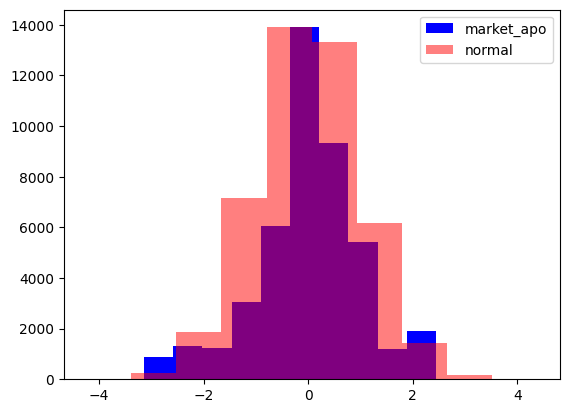

In [327]:
from numpy import random

# plt.hist(X_t0['market_apo'], color='blue', label='market_apo');
plt.hist((X_t0['market_apo']-X_t0['market_apo'].mean())/X_t0['market_apo'].std(), color='blue', label='market_apo');
plt.hist(np.random.normal(0, 1, len(X_t0['market_cmo'])), alpha=0.5, color='red', label='normal');
plt.legend()

Observamos que estas variables tienen datos atípicos para una variable numérica

In [328]:
numeric_var = numeric_var.drop(weird['binary'])
to_datetime_func = FunctionTransformer(lambda df: df.map(lambda ms: datetime.datetime.fromtimestamp(ms)))

first_transformer = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_var),
    ('categoric', MinMaxScaler(), weird['binary'] + ['borrow_times']),
    ('ts', to_datetime_func, timestamps), # ms a Timestamp según fecha POSIX
    ('tsdiff', FunctionTransformer(lambda ms: ms/1000), ts_diff_col) # ms a segundos
    ], remainder='passthrough', verbose_feature_names_out=False)
first_transformer.set_output(transform='pandas')

optimus = first_transformer.fit_transform(X_t0)
optimus

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,deposit_amount_sum_eth,deposit_count,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,market_ht_trendmode,unique_borrow_protocol_count,unique_lending_protocol_count,borrow_times,borrow_timestamp,first_tx_timestamp,last_tx_timestamp,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,wallet_address
0,-0.232649,-1.256644,-0.174730,-0.139263,-0.263437,-2.099846,-0.283573,-0.237842,-0.257612,-0.270986,-0.128783,-0.261122,-0.279313,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.519752,-0.043492,0.056233,-0.127205,-0.234284,-0.277434,-0.099228,-0.246179,-0.290332,-1.213694,-0.179349,-0.084194,-0.254934,-0.323385,-0.827621,0.538894,-0.174585,-0.130826,-0.058243,-0.173483,-0.142355,-0.173391,-0.326625,-0.240781,-0.048624,1.0,0.0,1.0,0.010543,2019-05-06 22:48:28,2018-09-17 19:44:19,2019-05-06 22:44:34,2001-09-08 22:46:39,2001-09-08 22:46:39,0.000,0x502cb8985b2c92a8d4bf309cdaa89de9be442708
1,-0.232440,-1.256641,-0.174730,-0.139067,-0.263431,-2.099838,-0.280540,-0.237831,-0.257612,-0.270986,-0.128801,-0.260796,-0.279312,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.519749,-0.043492,0.056233,-0.127225,-0.234030,-0.277434,-0.099228,-0.246179,-0.290332,-1.199911,-0.179349,-0.084194,-0.254934,-0.323385,-0.827606,0.538894,-0.160048,-0.130869,-0.058243,-0.168768,-0.142355,-0.173266,-0.326620,-0.240781,-0.048624,1.0,1.0,1.0,0.010543,2019-05-06 22:50:47,2018-09-17 19:44:19,2019-05-06 22:48:28,2001-09-08 22:46:39,2001-09-08 22:46:39,0.000,0x502cb8985b2c92a8d4bf309cdaa89de9be442708
2,-0.232184,-1.248831,-0.174730,-0.138924,-0.263417,-2.099834,-0.277506,-0.237805,-0.257612,-0.270986,-0.128816,-0.260469,-0.279309,-0.204929,-0.257618,-0.720426,0.125071,-0.248464,0.858076,-1.011346,-1.192479,1.038875,0.683379,-0.652171,0.096934,0.220307,0.967150,0.267883,0.059891,-0.248464,0.057592,-0.035233,-0.357680,-0.035270,-2.757783,-0.687659,1.195731,-0.056625,-0.329363,0.722749,0.722749,-0.165273,-1.507679,-0.043492,0.056233,-0.127245,-0.233776,-0.277434,-0.099228,-0.246179,-0.290332,-1.166098,-0.179349,-0.084194,-0.254934,-0.323385,-0.827601,0.538894,-0.160084,-0.130975,-0.058243,-0.168768,-0.142355,-0.173129,-0.326619,-0.240781,-0.048624,1.0,1.0,1.0,0.010543,2019-05-06 22:51:37,2018-09-17 19:44:19,2019-05-06 22:50:47,2001-09-08 22:46:39,2001-09-08 22:46:39,0.000,0x502cb8985b2c92a8d4bf309cdaa89de9be442708
3,0.9

In [ ]:
def ts_diff(df:pd.DataFrame):
    df['ts_diff_tx'] = df['last_tx_timestamp'] - df['first_tx_timestamp']
    df = df.rename(columns={'risky_first_last_tx_timestamp_diff':'ts_diff_risky_tx'})
    df.drop(columns=['last_tx_timestamp', 'first_tx_timestamp'])
    return df

ts_diff_transformer = FunctionTransformer(ts_diff) 

pre_pipe = Pipeline([('Misc', first_transformer), ('ts_diff', ts_diff_transformer), ('order', FunctionTransformer(lambda df: df[sorted(df.columns)]))])

optimus = pre_pipe.fit_transform(X_t0)
optimus

ValueError: A given column is not a column of the dataframe

In [330]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
def plot_qqplot(df, columns, num_cols=7, dist='norm'):
    columns = columns if not isinstance(columns, str) else [columns]
    num_rows = int(len(columns)/num_cols)+min(1, len(columns)%num_cols)
    fig, axes = plt.subplots(num_rows, num_cols if num_rows != 1 else len(columns), sharex=True)
    axes = axes.reshape(-1) if isinstance(axes, type(np.array([]))) else [axes]
    fig.set_figwidth(26 if num_rows > 1 else 3*len(columns))
    fig.set_figheight(num_rows*3)
    for i, col in enumerate(columns):
        data, _ = stats.probplot(df[col], dist=dist, plot=axes[i])
        axes[i].set_title(col)
        if i!=0:
            axes[i].set_ylabel('')
        if isinstance(axes, type(np.array([]))) and i!=(len(axes)-1):
            axes[i].set_xlabel('')
    fig.set
    plt.show()

KeyError: 'market_ht_trendmode'

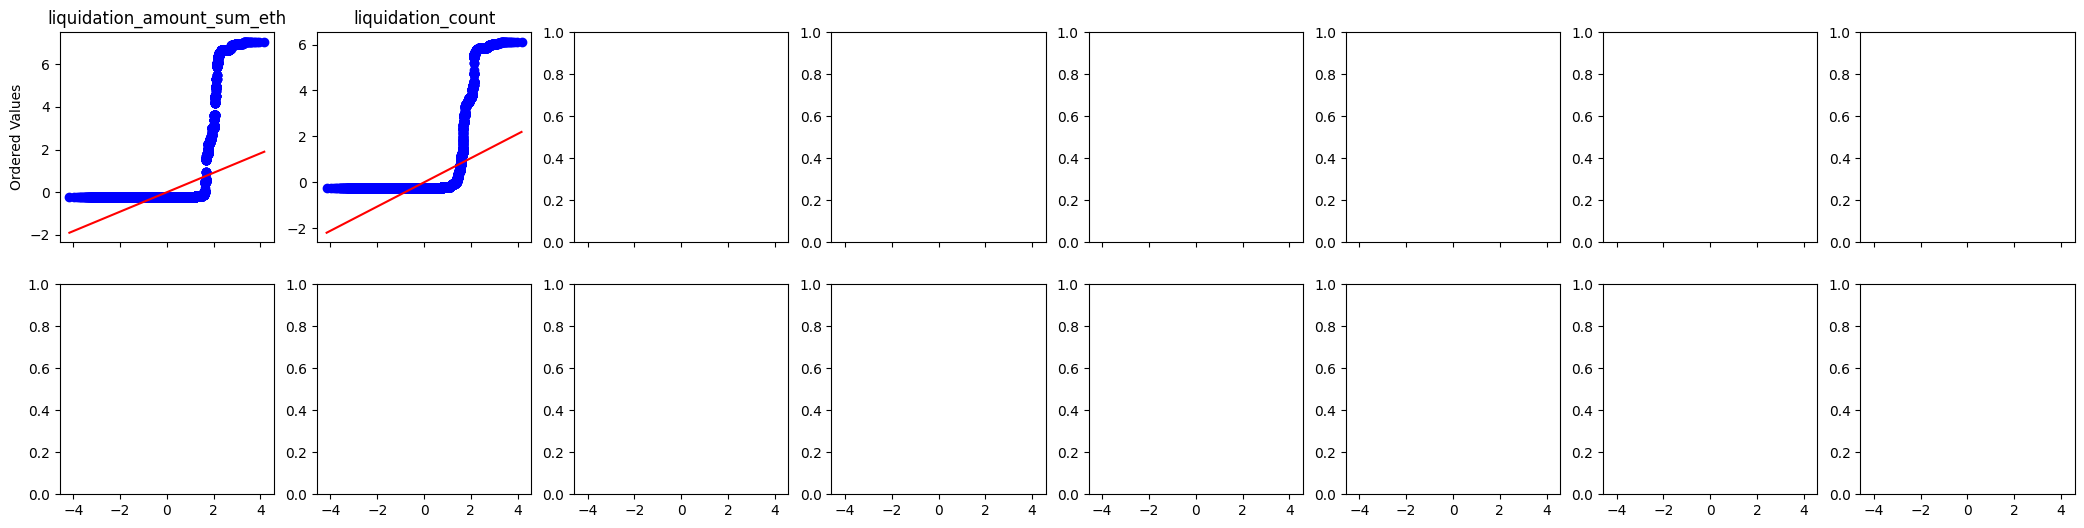

In [331]:
plot_qqplot(optimus[numeric_var], cuasiconstant, num_cols=8)

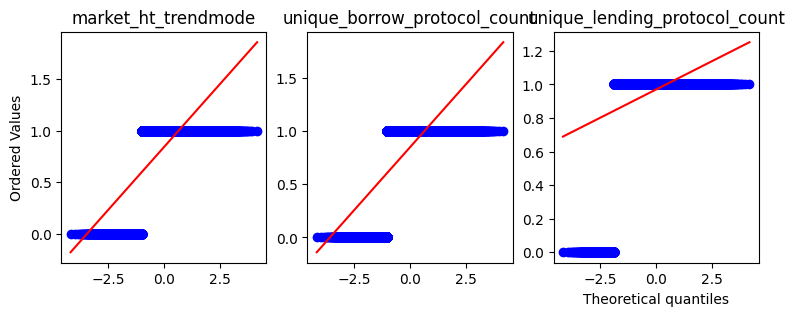

In [ ]:
plot_qqplot(optimus, weird['binary'])

qqplot esperado para varible binaria

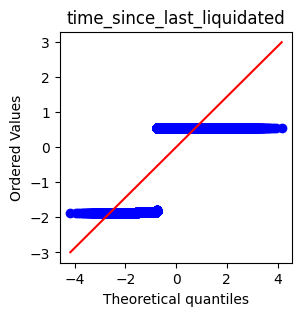

In [ ]:
plot_qqplot(optimus, weird['max_prop'])

Este campo se asumirá como variable binaria

liquidation_amount_sum_eth, liquidation_count, risk_factor_above_threshold_daily_count, risky_sum_outgoing_amount_eth, risky_tx_count, risky_unique_contract_count, withdraw_deposit_diff_if_positive_eth


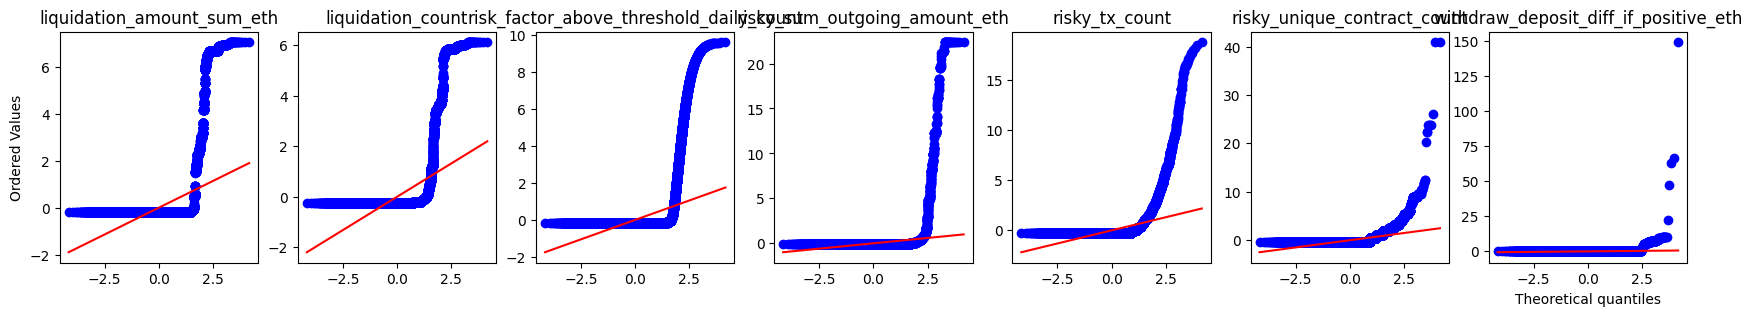

In [ ]:
print(", ".join(weird['min_prop']))
plot_qqplot(optimus, weird['min_prop'])

Podemos observar en las primeras 5 variables un comportamiento parecido a una variable binaria. Para facilitar la predicción al modelo, podemos definir para ellas 3 o 4 bins, donde los bins 2 y 3 serían valores de transición desde los menores a los mayores valores encontrados.

Para las demás variables, vemos comportamientos interesantes. Por ejemplo para `max_market_drawdown_365d` se observan valores escalonados, lo que también podría permitirnos simplificar estos valores en bins. A su vez, vemos que varias se comportan de manera normal.

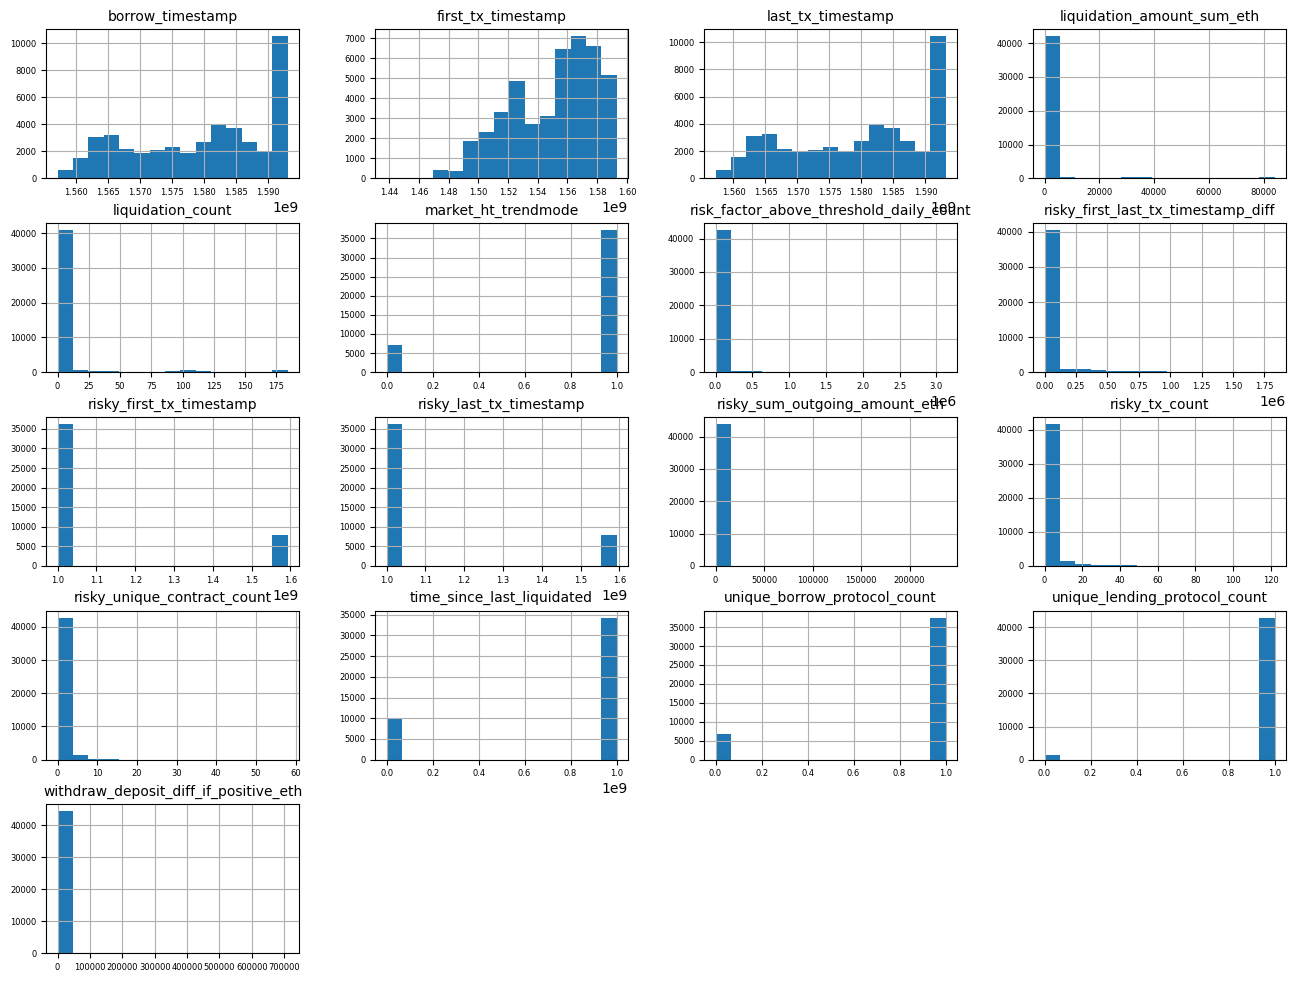

In [ ]:
pd.set_option("display.max_columns", maxcols)
# Histogramas para revisar el comportamiento de las variable
axes = X_t0[X_t0.drop(columns=weird['not']).columns].hist(figsize=(16,12), bins=15)
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

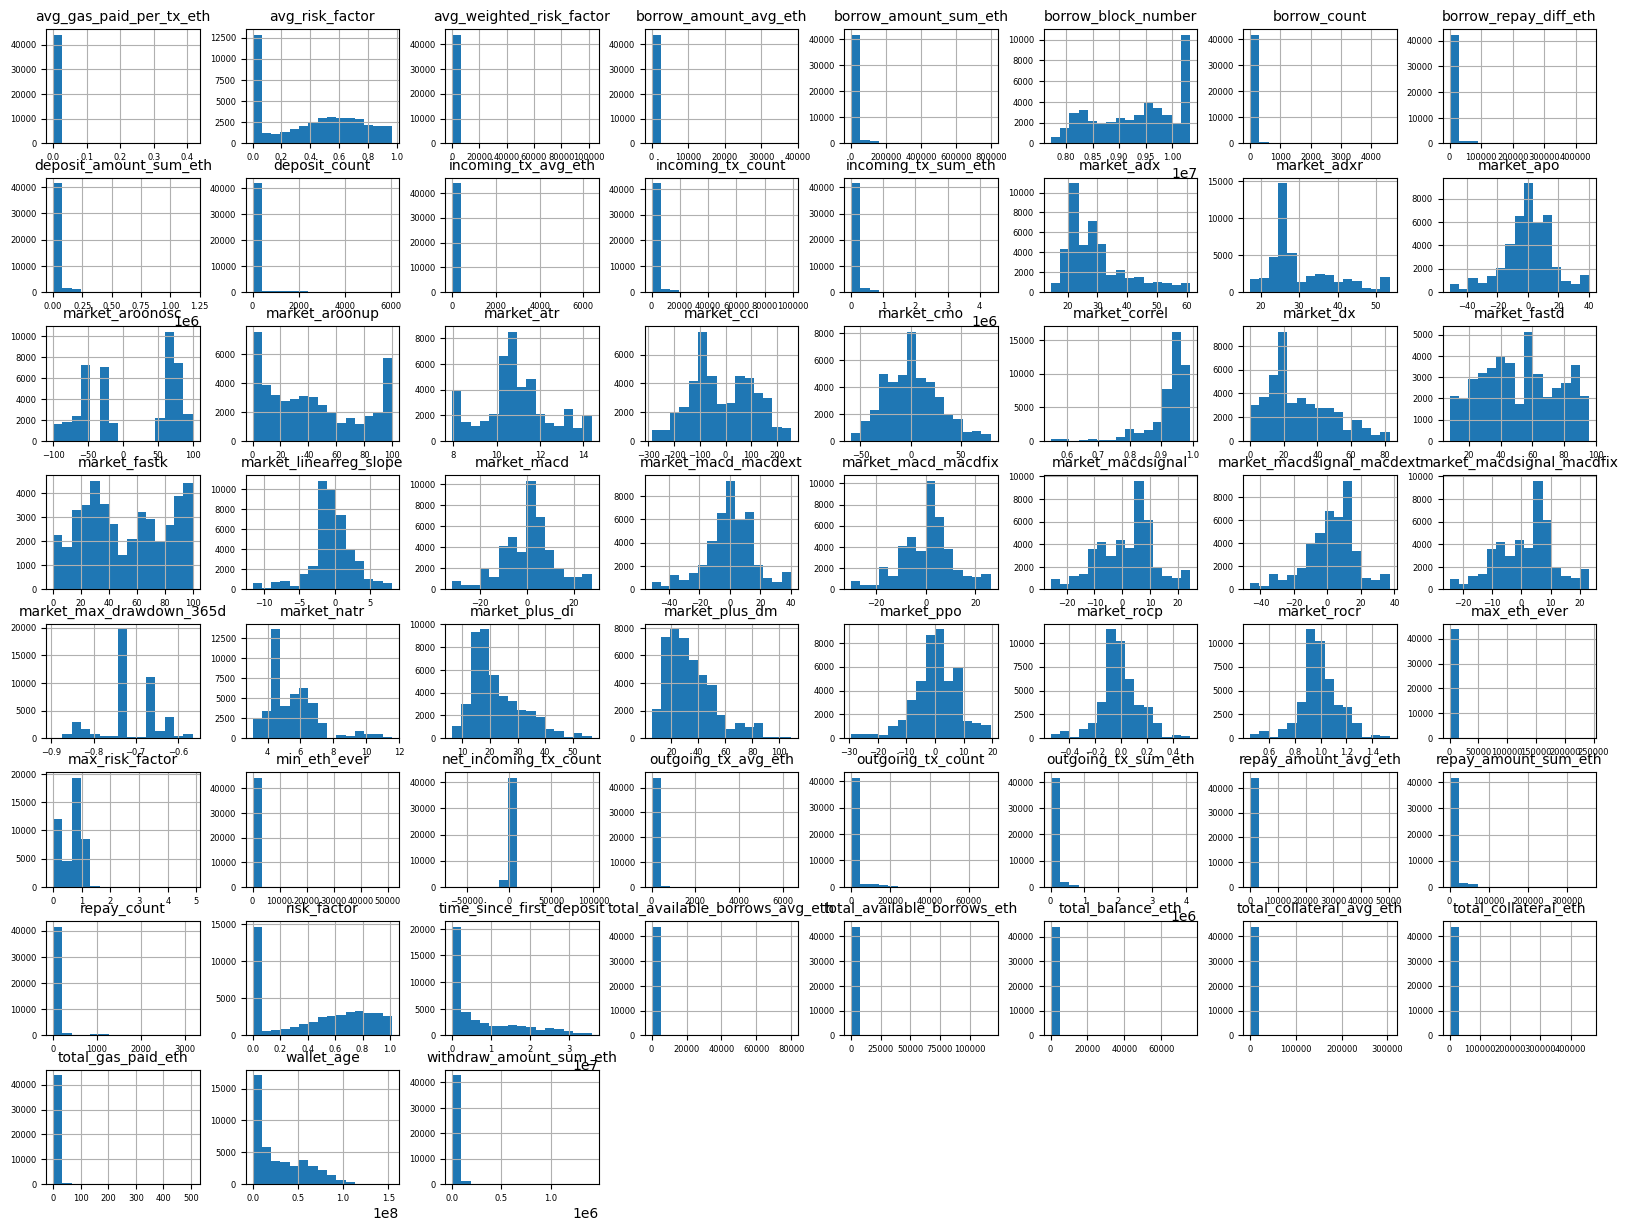

In [ ]:
axes = X_t0[weird['not']].hist(figsize=(20,15), bins=15)
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

In [ ]:
X_corr = X_t0[weird['not']].corr().stack()
X_corr = X_corr[X_corr.index.get_level_values(0) != X_corr.index.get_level_values(1)]
X_corr

avg_gas_paid_per_tx_eth  avg_risk_factor            -0.063659
                         avg_weighted_risk_factor    0.021849
                         borrow_amount_avg_eth       0.053022
                         borrow_amount_sum_eth       0.003014
                         borrow_block_number         0.151973
                                                       ...   
withdraw_amount_sum_eth  total_balance_eth           0.071456
                         total_collateral_avg_eth    0.425276
                         total_collateral_eth        0.391980
                         total_gas_paid_eth          0.299858
                         wallet_age                  0.175796
Length: 3422, dtype: float64

In [ ]:
X_corr = X_t0[weird['not']].corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = X_corr.columns,
        y = X_corr.index,
        z = np.array(X_corr),
        text=X_corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title_text='Correlación entre las variables numéricas',
                    height=800, width=1400)
fig.show()

#### **2. Modelos con Scikit-Learn (Entrega Parcial 1)**

##### **2.1. Análisis Exploratorio de Datos [0.5 puntos]**  
Realicen un análisis que explore patrones, tendencias y relaciones clave en los datos. Incluyan:  
- Estadísticas descriptivas generales.  
- Visualizaciones para identificar distribuciones, valores atípicos y posibles relaciones entre variables.  
- Cualquier observación relevante que pueda influir en las etapas posteriores del proyecto.  

El informe debe ser detallado y profesional, demostrando no solo la implementación técnica, sino también una comprensión profunda de los datos y la problemática planteada.



##### **2.2 Preprocesamiento de Datos [0.25 puntos]**

Esta sección se centra en la limpieza y preparación de los datos para garantizar que sean adecuados para el entrenamiento y evaluación de los modelos. Es fundamental ejecutar un **`train_test_split`** para dividir los datos en conjuntos de entrenamiento y validación, siguiendo la proporción establecida (por ejemplo, 70/30). 

Se espera la implementación de diversas técnicas de preprocesamiento, tales como:  
- **Uso de `ColumnTransformer`:** Permite aplicar transformaciones específicas a diferentes columnas de manera eficiente.  
- **Imputación de valores nulos:** Elija una estrategia adecuada (media, mediana, moda, etc.) para completar los datos faltantes.  
- **Discretización de variables:** Convierte variables numéricas continuas en categóricas, si resulta útil para el modelo.  
- **Estandarización o normalización:** Mejora el rendimiento de algunos algoritmos que son sensibles a la escala de los datos.  
- Otras transformaciones necesarias dependiendo de las características específicas del conjunto de datos.

El proceso debe estar bien documentado y justificado en el informe, explicando las decisiones tomadas en función de los datos y los objetivos del proyecto.

---

In [ ]:
y_t0.value_counts()

target
1         22656
0         21640
Name: count, dtype: int64

Dado que las clases están en proporciones relativamente similares, no consideramos necesario 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(optimus, y_t0.values, 
                                                    test_size=0.3, random_state=29, shuffle=True,)

##### **2.3 Baseline [0.25 puntos]**

En esta sección se debe construir el modelo más sencillo posible que pueda resolver el problema planteado, conocido como **modelo baseline**. Su propósito es servir como referencia para comparar el rendimiento de los modelos más avanzados desarrollados en etapas posteriores.  

Pasos requeridos:  
- Implemente, entrene y evalúe un modelo básico utilizando un pipeline.  
- Asegúrese de incluir en el pipeline las transformaciones del preprocesamiento realizadas previamente junto con un clasificador básico.  
- Evalúe el modelo y presente el informe de métricas utilizando **`classification_report`**.  

Documente claramente cómo se creó el modelo, las decisiones tomadas y los resultados obtenidos. Este modelo será la base comparativa en las secciones posteriores.

---

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Aplico labelEncoder a la col 'wallet_address'

encoder = LabelEncoder()
encoder.fit(X_t0.wallet_address)

X_train.wallet_address  = encoder.transform(X_train.wallet_address)
X_test.wallet_address = encoder.transform(X_test.wallet_address)

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)

# dummy.score:Return the mean accuracy on the given test data and labels.
dummy_clf.score(X_test, y_test)

0.5107231544886749

In [ ]:
lsvc = LinearSVC(random_state=29)
lsvc.fit(X_train.drop(columns=timestamps), y_train)
y_lsvc = lsvc.predict(X_test.drop(columns=timestamps))
lsvc.score(X_test.drop(columns=timestamps), y_test)

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7533298216570096

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Text(0, 0.5, 'True positive rate')

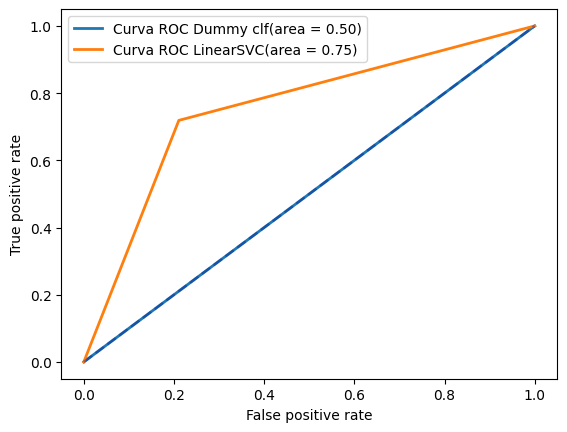

In [ ]:
# AUC curve
models = ['Dummy clf', 'LinearSVC']

for i, y in enumerate([y_dummy, y_lsvc]):
    fpr, tpr, thresholds = roc_curve(y_test, y, pos_label=2)
    auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(y_test, y,)
    roc_auc = roc_auc_score(y_test, y)

    plt.plot(fpr, tpr, lw=2, label=f'Curva ROC {models[i]}(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.3)
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [ ]:
print(classification_report(y_test, y_dummy))
print(classification_report(y_test, y_lsvc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6502
           1       0.51      1.00      0.68      6787

    accuracy                           0.51     13289
   macro avg       0.26      0.50      0.34     13289
weighted avg       0.26      0.51      0.35     13289

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      6502
           1       0.78      0.72      0.75      6787

    accuracy                           0.75     13289
   macro avg       0.75      0.75      0.75     13289
weighted avg       0.76      0.75      0.75     13289



d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
lsvc.score(X_test.drop(columns=timestamps), y_test)

0.7533298216570096

The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all relevant results (high recall).

In [ ]:
y_score = lsvc.decision_function(X_test.drop(columns=timestamps))

display = PrecisionRecallDisplay.from_predictions(
    y_lsvc, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

NameError: name 'PrecisionRecallDisplay' is not defined